# Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy import stats

# Some constants
data_file = 'https://raw.githubusercontent.com/hieubkvn123/MH6321-project/main/data/full-data.csv'

# Load data

In [3]:
df_full = pd.read_csv(data_file)

In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11627 entries, 0 to 11626
Data columns (total 39 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RANDID    11627 non-null  int64  
 1   SEX       11627 non-null  int64  
 2   TOTCHOL   11218 non-null  float64
 3   AGE       11627 non-null  int64  
 4   SYSBP     11627 non-null  float64
 5   DIABP     11627 non-null  float64
 6   CURSMOKE  11627 non-null  int64  
 7   CIGPDAY   11548 non-null  float64
 8   BMI       11575 non-null  float64
 9   DIABETES  11627 non-null  int64  
 10  BPMEDS    11034 non-null  float64
 11  HEARTRTE  11621 non-null  float64
 12  GLUCOSE   10187 non-null  float64
 13  educ      11332 non-null  float64
 14  PREVCHD   11627 non-null  int64  
 15  PREVAP    11627 non-null  int64  
 16  PREVMI    11627 non-null  int64  
 17  PREVSTRK  11627 non-null  int64  
 18  PREVHYP   11627 non-null  int64  
 19  TIME      11627 non-null  int64  
 20  PERIOD    11627 non-null  in

# Age versus cardiovascular risks

In [11]:
heart_diseases = [
    'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP'
]

disease_dict = {
    'PREVCHD' : 'Coronary Heart Disease',
    'PREVAP' : 'Angina Pectoris',
    'PREVMI' : 'Myocardial Infarction',
    'PREVSTRK' : 'Stroke',
    'PREVHYP' : 'Hypertensive'
}

cardiovascular_risks = [
    'TOTCHOL', 'SYSBP', 'DIABP', # Cholesterol + Blood pressure
    'CIGPDAY', # Smoking habits
    'BMI', 'GLUCOSE', # Fat people
]

risk_dict = {
    'TOTCHOL' : 'Serum cholesterol',
    'SYSBP' : 'Systolic blood pressure',
    'DIABP' : 'Diastolic blood pressure',
    'CIGPDAY' : 'Cigarettes per day',
    'BMI' : 'Body mass index',
    'GLUCOSE' : 'Casual glucose'
}

## 1. Divide the data into age groups

In [6]:
age_bins = [35, 45, 55, 65, 75, 85]
age_labels = ['35-44', '44-54', '55-64', '65-74', '75-84']
df_full['AGEGROUP'] = pd.cut(df_full['AGE'], bins=age_bins, labels=age_labels, right=False)

In [7]:
df_full.head(5)

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP,AGEGROUP
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,0,8766,6438,6438,6438,8766,6438,8766,8766,35-44
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,0,8766,6438,6438,6438,8766,6438,8766,8766,44-54
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,44-54
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,44-54
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,55-64


## 2. Visualize cardiovascular risks of different age groups
- Among people with cardiovascular diseases, is there a significant difference in cardiovascular risks across different age groups? For example, among people with hypertension, is there a significant difference in the bmi of people from 35-44 and people from 55-64 years of age?

- For each age group, is there a significant difference in the intensity of cardiovascular risks between non-prevalent and prevalent heart disease? For example, among people from 35-44 years of age, is there a difference in the level of cholesterol between people with Angina Pectoris and people who do not have AP?

### 2.1. Initial visualizations

[INFO] VISUALIZATION FOR : CORONARY HEART DISEASE


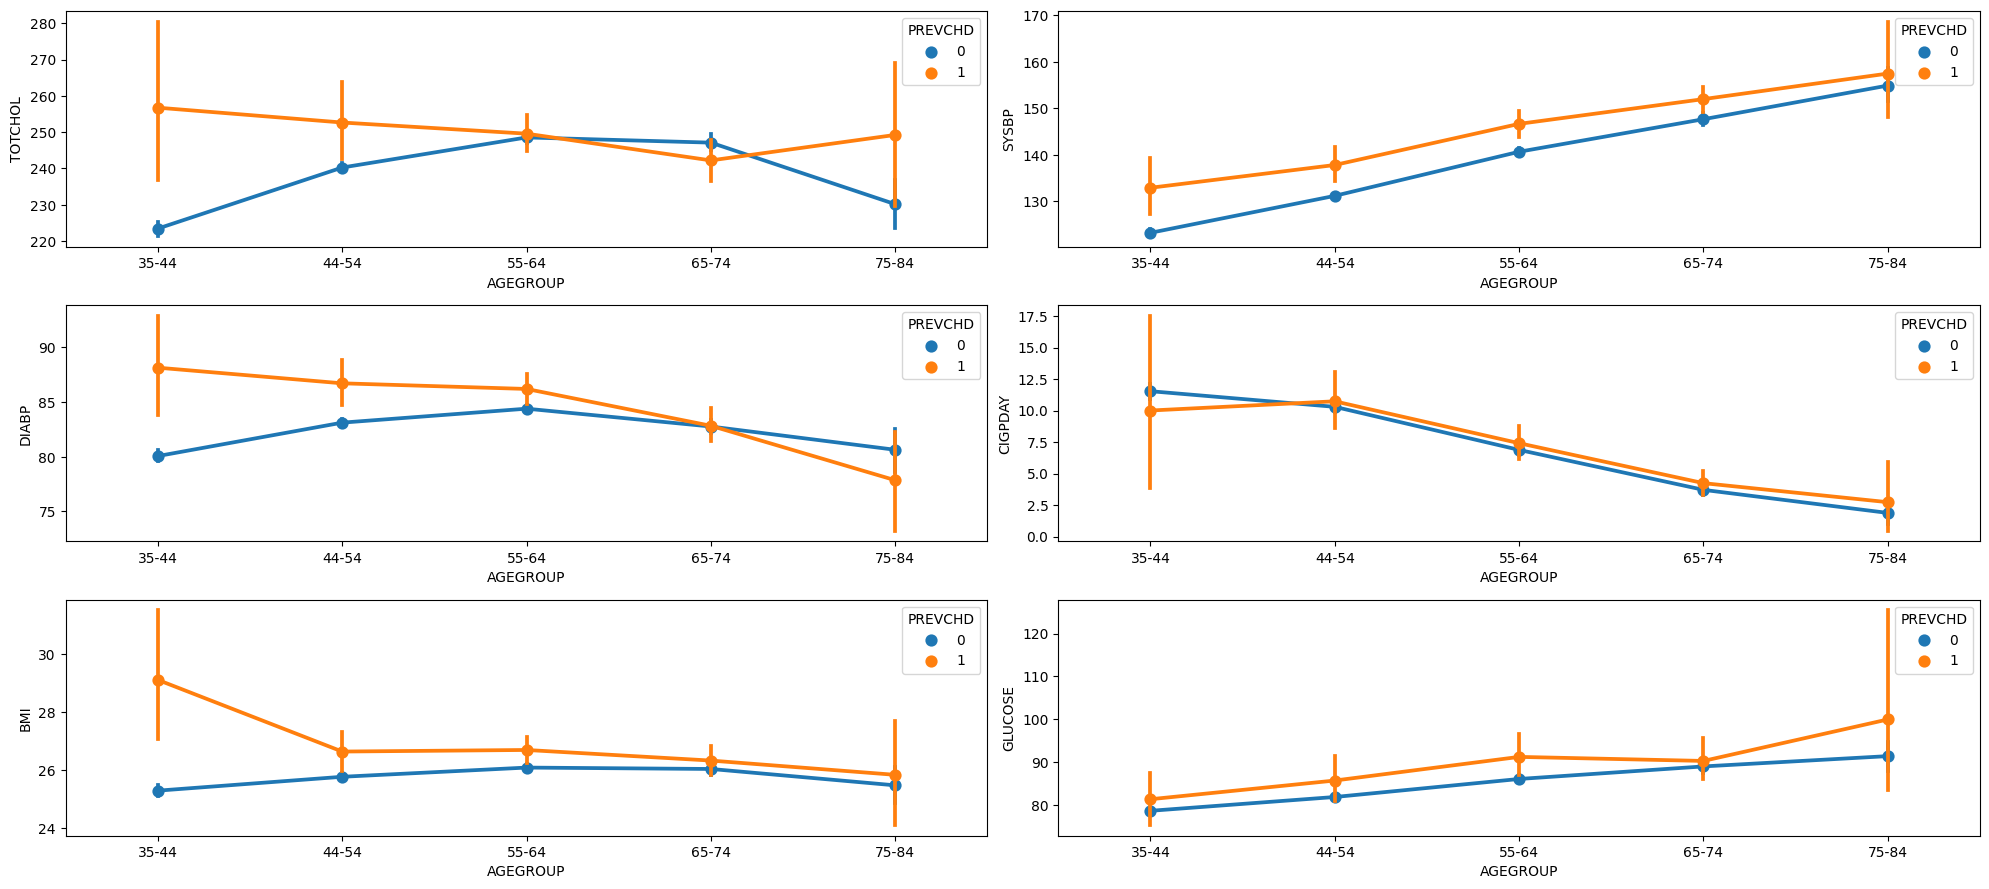


[INFO] VISUALIZATION FOR : ANGINA PECTORIS


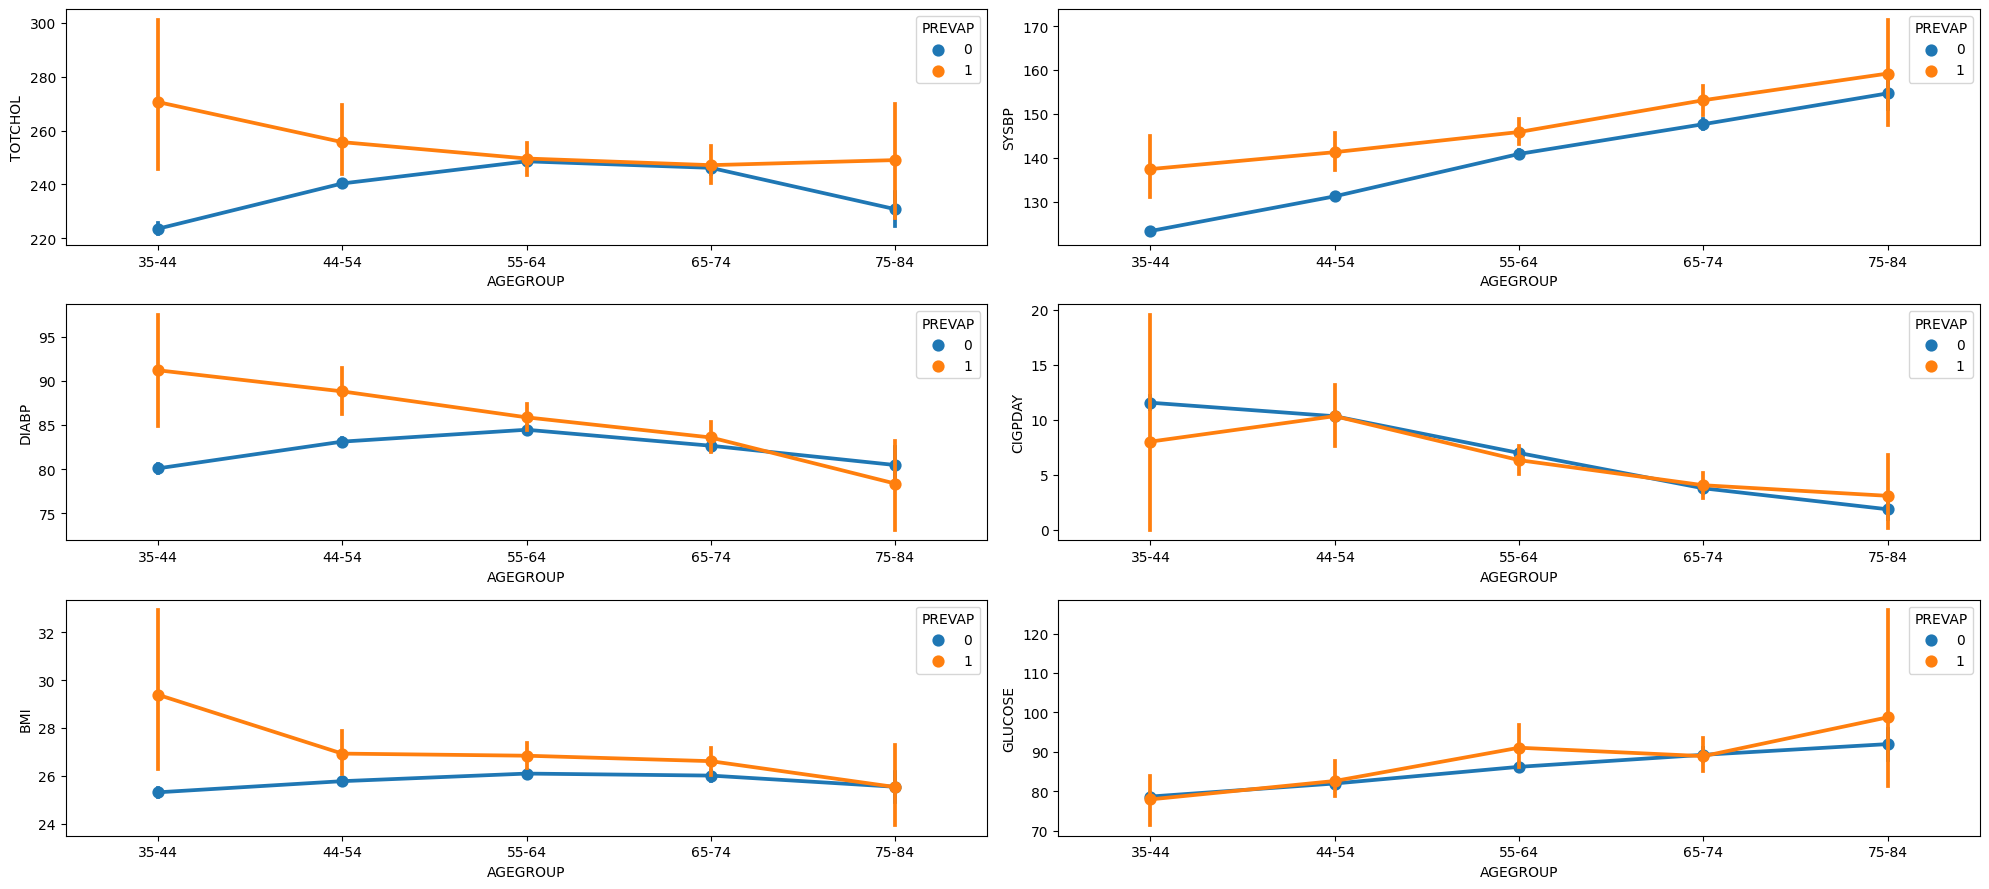


[INFO] VISUALIZATION FOR : MYOCARDIAL INFARCTION


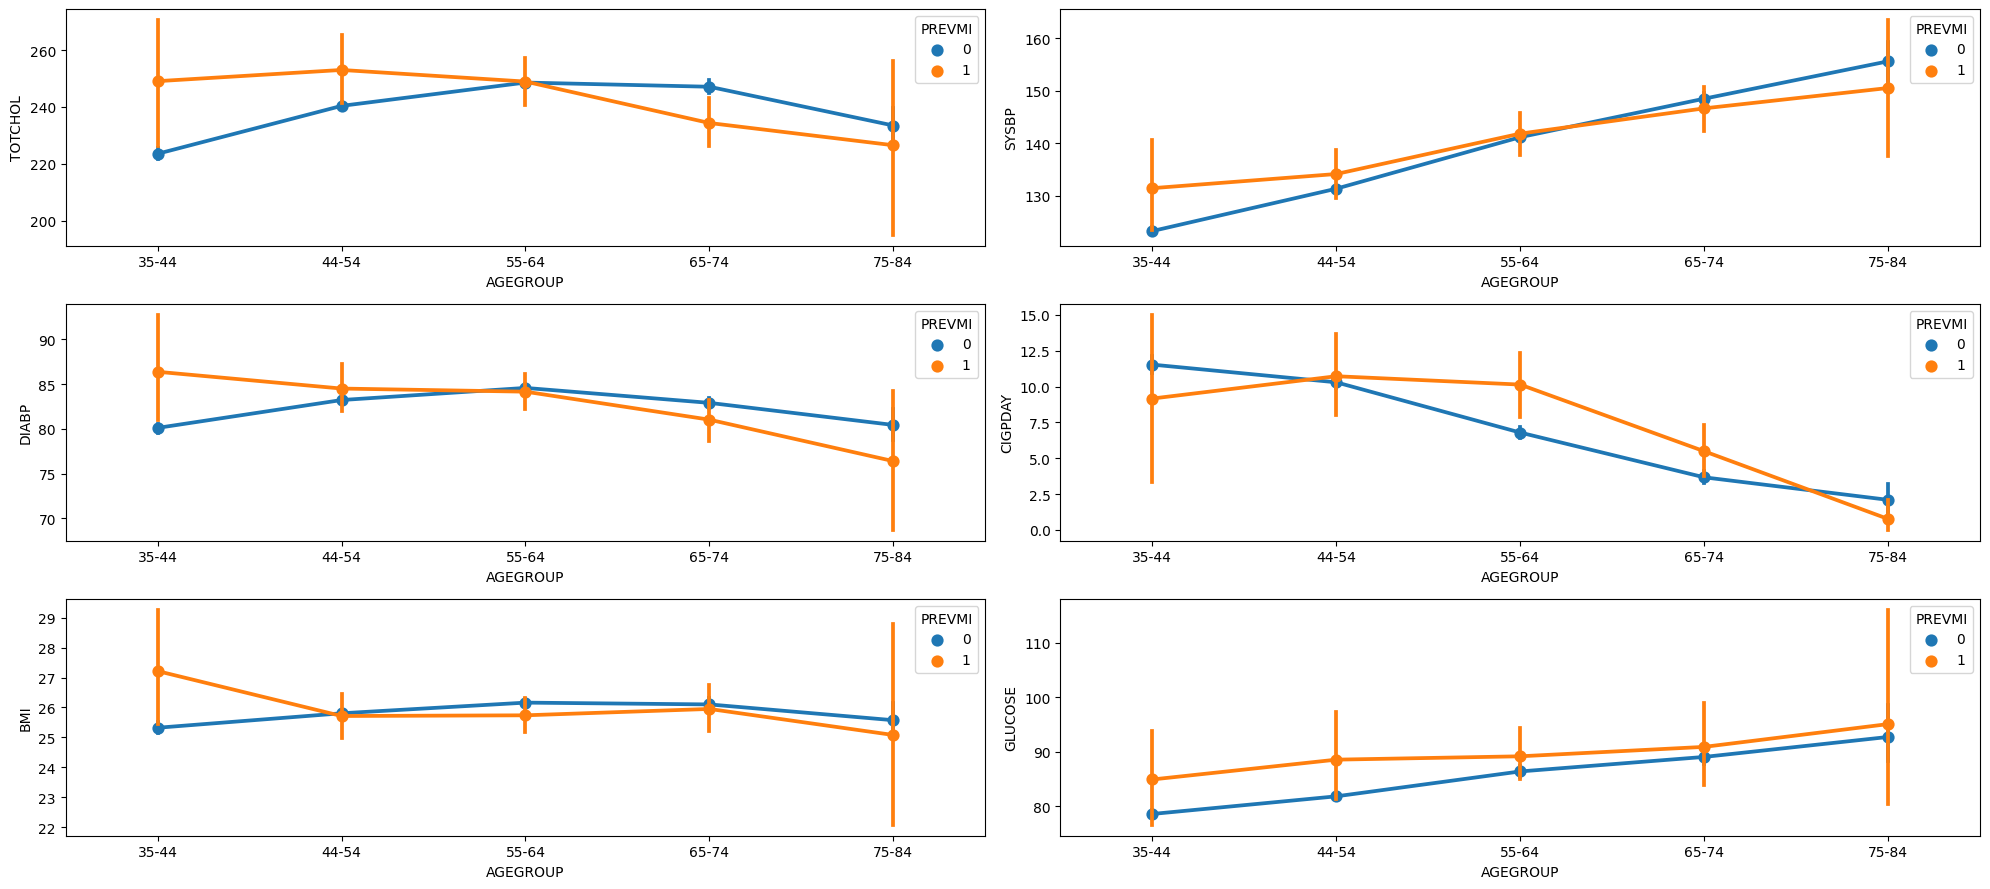


[INFO] VISUALIZATION FOR : STROKE


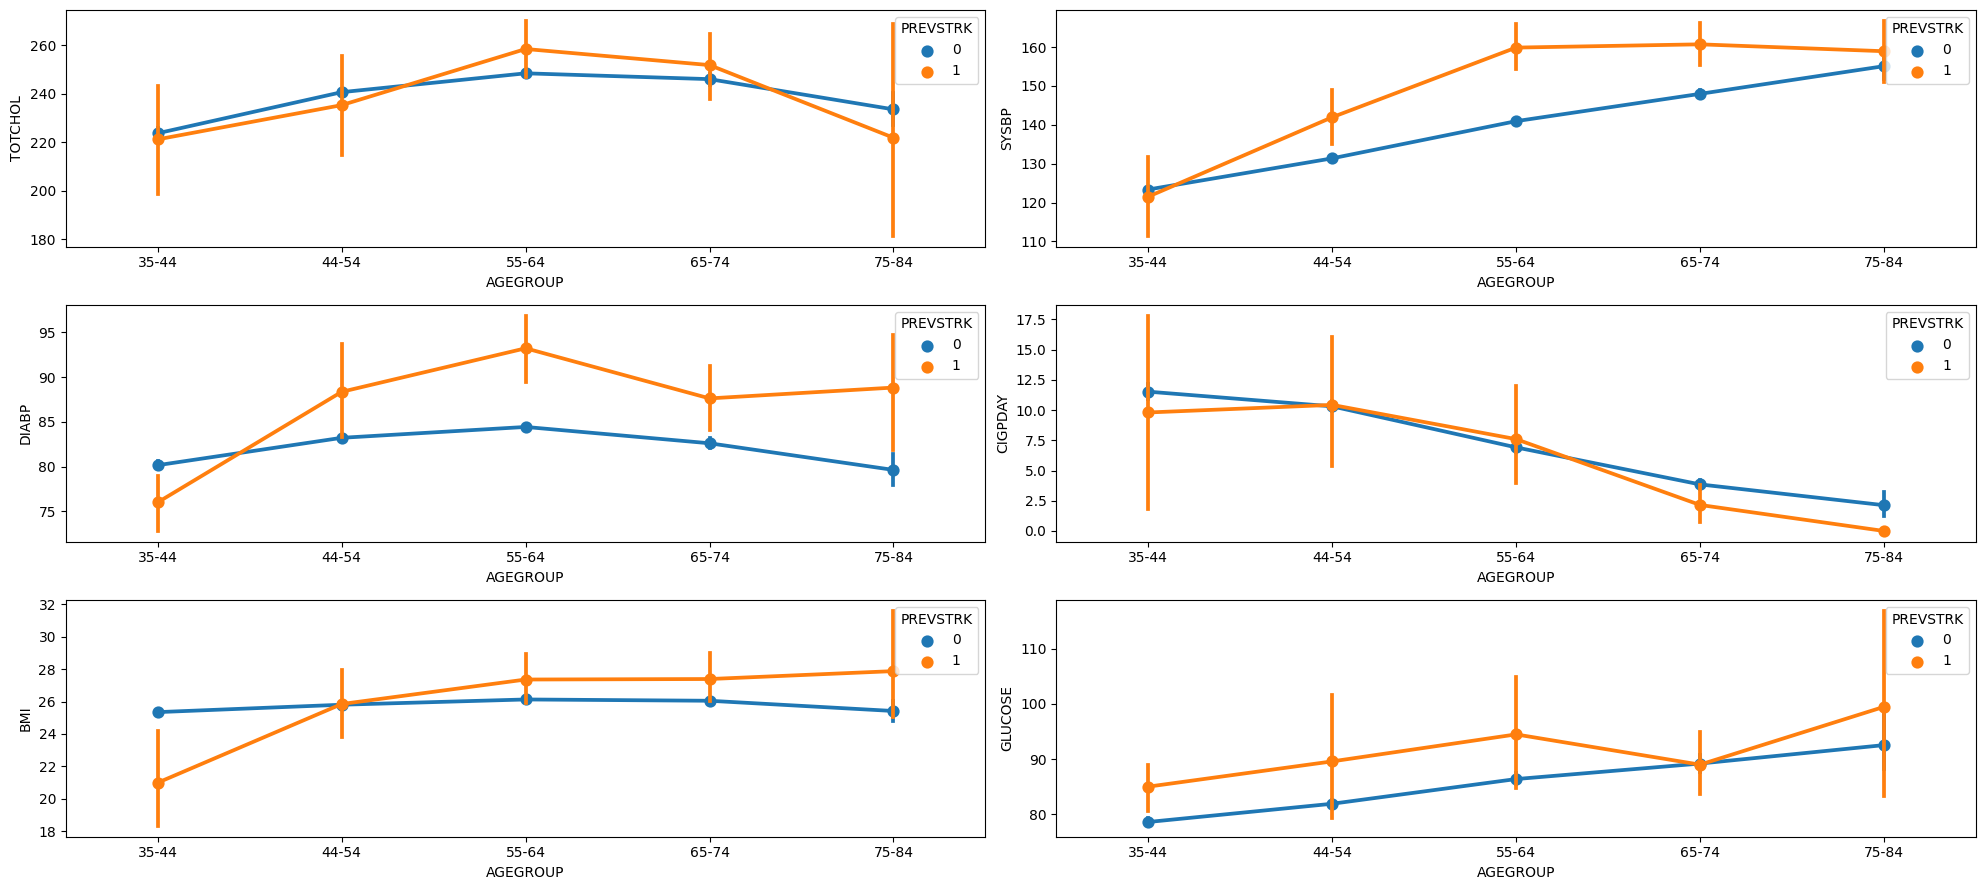


[INFO] VISUALIZATION FOR : HYPERTENSIVE


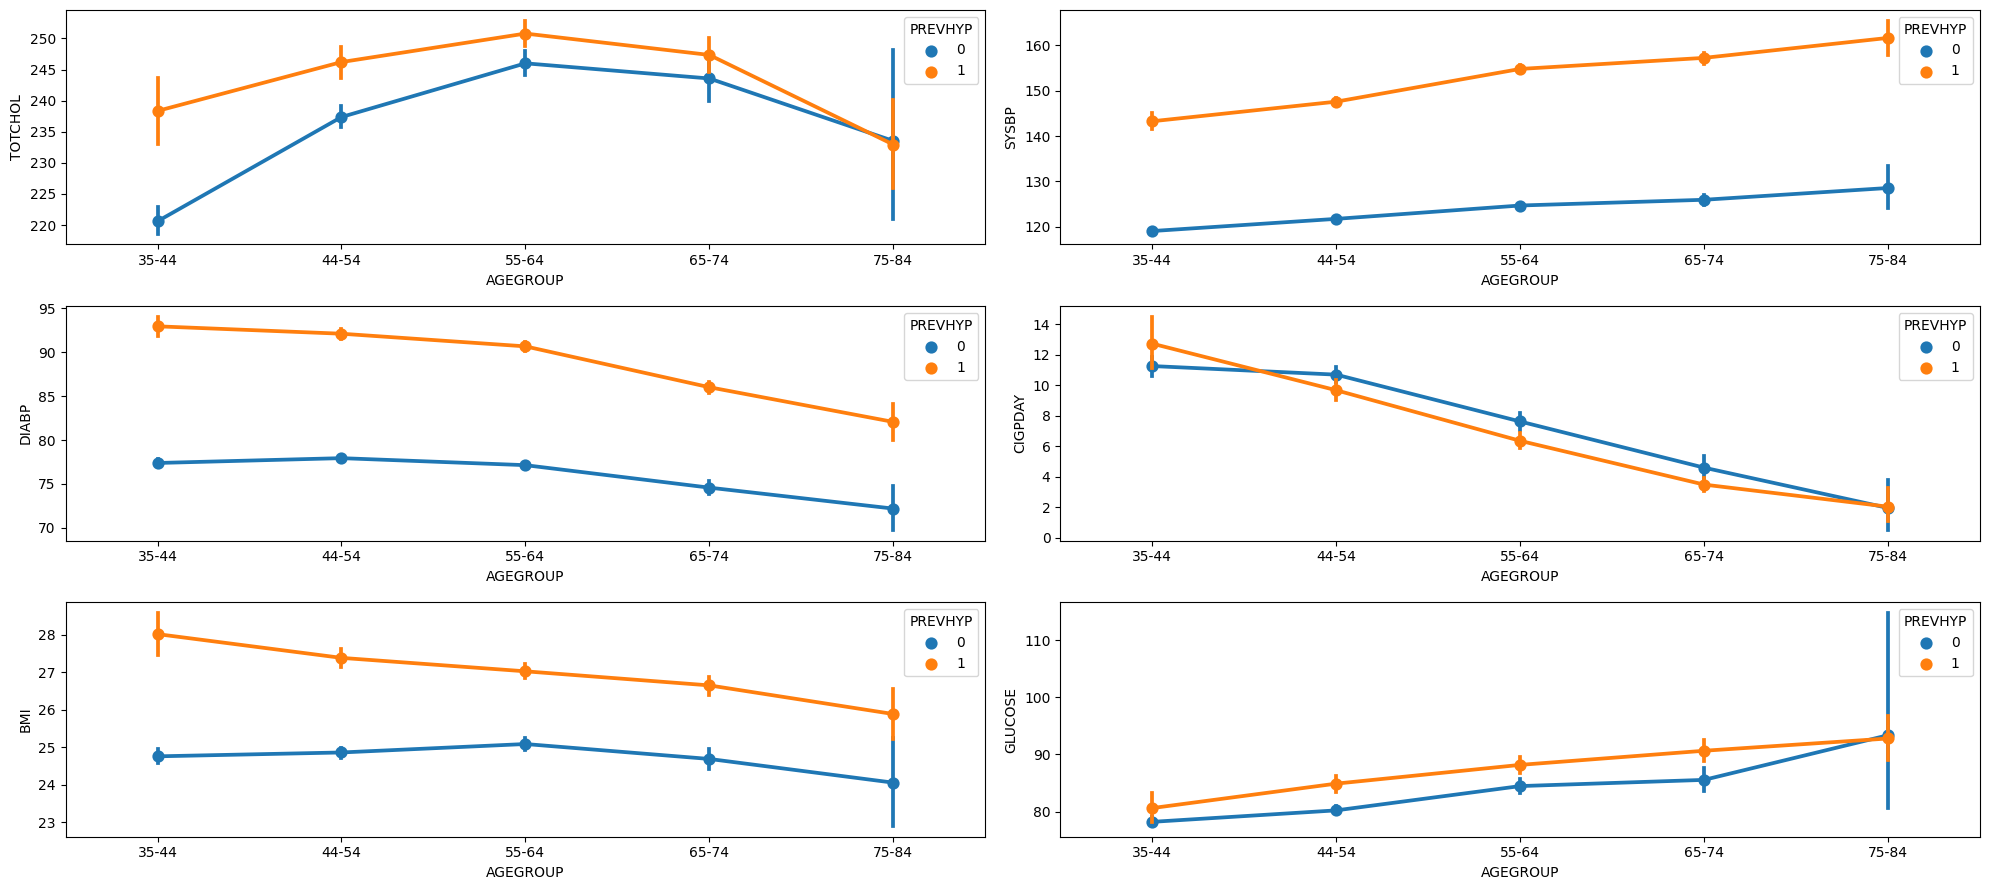

In [8]:
def visualize_cardiovascular_risks(disease):
  print(f'[INFO] VISUALIZATION FOR : {disease_dict[disease].upper()}')
  fig, axes = plt.subplots(3,2, figsize=(20, 9))

  for i in range(len(cardiovascular_risks)):
    row = i // 2
    col = i  % 2
    sns.pointplot(data=df_full, y=cardiovascular_risks[i], x='AGEGROUP', hue=disease,ax=axes[row][col])
  plt.tight_layout()
  plt.show()

for disease in heart_diseases:
  visualize_cardiovascular_risks(disease)
  print('=' * 150 + '\n')

### 2.2. How cardiovascular risks vary with age
- For every cardiovascular disease, an one-way ANOVA test will be conducted for each risk factor to identify if certain risk factors that varies significantly with respect to age.
- Upon identifying these factors, it is suggested that doctors take into account age factors when taking measurements and making diagnosis.

In [9]:
alpha = 0.001
def oneway_f_test(disease, risk):
  # Get subjects with corresponding disease
  df_disease = df_full[df_full[disease] == 1]

  # Remove subjects with empty risk factor
  df_disease = df_disease[~df_disease[risk].isna()]

  # Oneway F-test for the groups
  groups = [df_disease[df_disease['AGEGROUP'] == group][risk].values for group in age_labels]
  results = stats.f_oneway(*groups)

  return results.statistic, results.pvalue

for disease in heart_diseases:
  print('\n[INFO] One-way ANOVA for', disease_dict[disease].upper())
  for risk in cardiovascular_risks:
    F, pvalue = oneway_f_test(disease, risk)
    if(pvalue < alpha):
      print(f' - Significant result for {risk}. F-statistic = {F}, pvalue = {pvalue}')


[INFO] One-way ANOVA for Coronary Heart Disease
 - Significant result for SYSBP. F-statistic = 10.904213559218999, pvalue = 1.2713713496297171e-08
 - Significant result for DIABP. F-statistic = 6.19157558857047, pvalue = 6.530532591603996e-05
 - Significant result for CIGPDAY. F-statistic = 10.02202836407505, pvalue = 6.343157247282405e-08

[INFO] One-way ANOVA for Angina Pectoris
 - Significant result for SYSBP. F-statistic = 6.6170771974079585, pvalue = 3.2205944706946976e-05
 - Significant result for DIABP. F-statistic = 5.376381763865207, pvalue = 0.00029221598889696016
 - Significant result for CIGPDAY. F-statistic = 6.519141632833189, pvalue = 3.843565657325848e-05

[INFO] One-way ANOVA for Myocardial Infarction

[INFO] One-way ANOVA for Stroke
 - Significant result for SYSBP. F-statistic = 6.853732193285147, pvalue = 4.3668607469672156e-05

[INFO] One-way ANOVA for Hypertensive
 - Significant result for TOTCHOL. F-statistic = 8.909280628994168, pvalue = 3.6317309709053226e-07
 

### 2.3. Prominent risk factors - Independent t-test
- For each age groups, identify the most prominent risk factors by conducting an independent t-test on the groups of prevalent disease and non-prevalent diseases subjects.

In [16]:
alpha = 0.001
for disease in heart_diseases:
  print('\n[INFO] Prominent risk factors for ', disease_dict[disease].upper())
  for age_group in age_labels:
    # Get the groups
    df_age = df_full[df_full['AGEGROUP'] == age_group]
    df_prev = df_age[df_age[disease] == 1]
    df_nonprev = df_age[df_age[disease] == 0]

    # Get all prominent risk factors
    prominent_risks = []
    for risk in cardiovascular_risks:
      prev = df_prev[risk].dropna().values
      nonprev = df_nonprev[risk].dropna().values

      # Conduct independent t-test
      results = stats.ttest_ind(prev, nonprev)
      if(results.pvalue < alpha):
        prominent_risks.append(f'{risk} (pvalue={results.pvalue:.4f})')
    print(f' - Age group {age_group} : {prominent_risks}')
  print('---------------------------------------------------------------------')



[INFO] Prominent risk factors for  CORONARY HEART DISEASE
 - Age group 35-44 : ['TOTCHOL (pvalue=0.0009)', 'BMI (pvalue=0.0001)']
 - Age group 44-54 : ['SYSBP (pvalue=0.0001)', 'DIABP (pvalue=0.0002)']
 - Age group 55-64 : ['SYSBP (pvalue=0.0000)']
 - Age group 65-74 : []
 - Age group 75-84 : []
---------------------------------------------------------------------

[INFO] Prominent risk factors for  ANGINA PECTORIS
 - Age group 35-44 : ['TOTCHOL (pvalue=0.0005)', 'DIABP (pvalue=0.0008)']
 - Age group 44-54 : ['SYSBP (pvalue=0.0000)', 'DIABP (pvalue=0.0000)']
 - Age group 55-64 : ['SYSBP (pvalue=0.0010)']
 - Age group 65-74 : []
 - Age group 75-84 : []
---------------------------------------------------------------------

[INFO] Prominent risk factors for  MYOCARDIAL INFARCTION
 - Age group 35-44 : []
 - Age group 44-54 : []
 - Age group 55-64 : ['CIGPDAY (pvalue=0.0006)']
 - Age group 65-74 : []
 - Age group 75-84 : []
------------------------------------------------------------------

### 2.4. Prominent risk factors - logistic regression

## 3. Gender vs. heart diseases

## 4. Survival analysis - first time after first stroke